In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from imblearn.combine import SMOTEENN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #for Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier, export_text #for Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier #for Random Forest Classifier
from sklearn.model_selection import train_test_split #for train_test_split function

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  #for model performance metrics

In [3]:
#reading data
df = pd.read_csv('/content/gdrive/My Drive/IBM_Assignment/Financial Dataset.csv', delimiter = ';') 
print("Number of Rows & Columns :", df.shape, "\n")
df.head()

Number of Rows & Columns : (41188, 21) 



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
#listing name of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
#checking missing values in data
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Exploratory data analysis

In [6]:
#checking distribution of dependent variable
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [7]:
#summary statistics of numeric columns
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


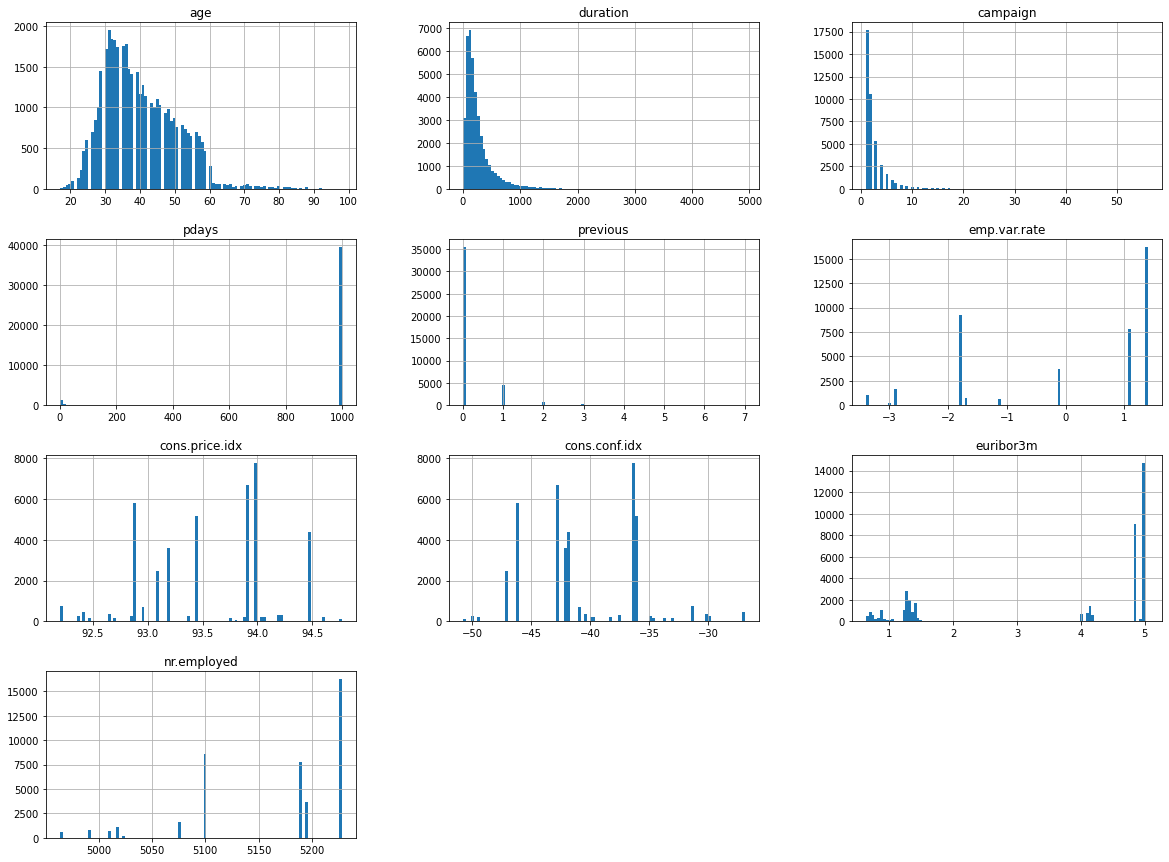

In [8]:
#distribution of all numeric columns
df.hist(figsize=(20, 15), bins = 100, xlabelsize = 10, ylabelsize = 10);

There is some slight skewness in age and duration variable which might indicate presence of some outliers in the data. Also looking at distribution, it appears that pdays and previous follow distribution of categorical nature, not continuous. So, we can create categorical features from them.

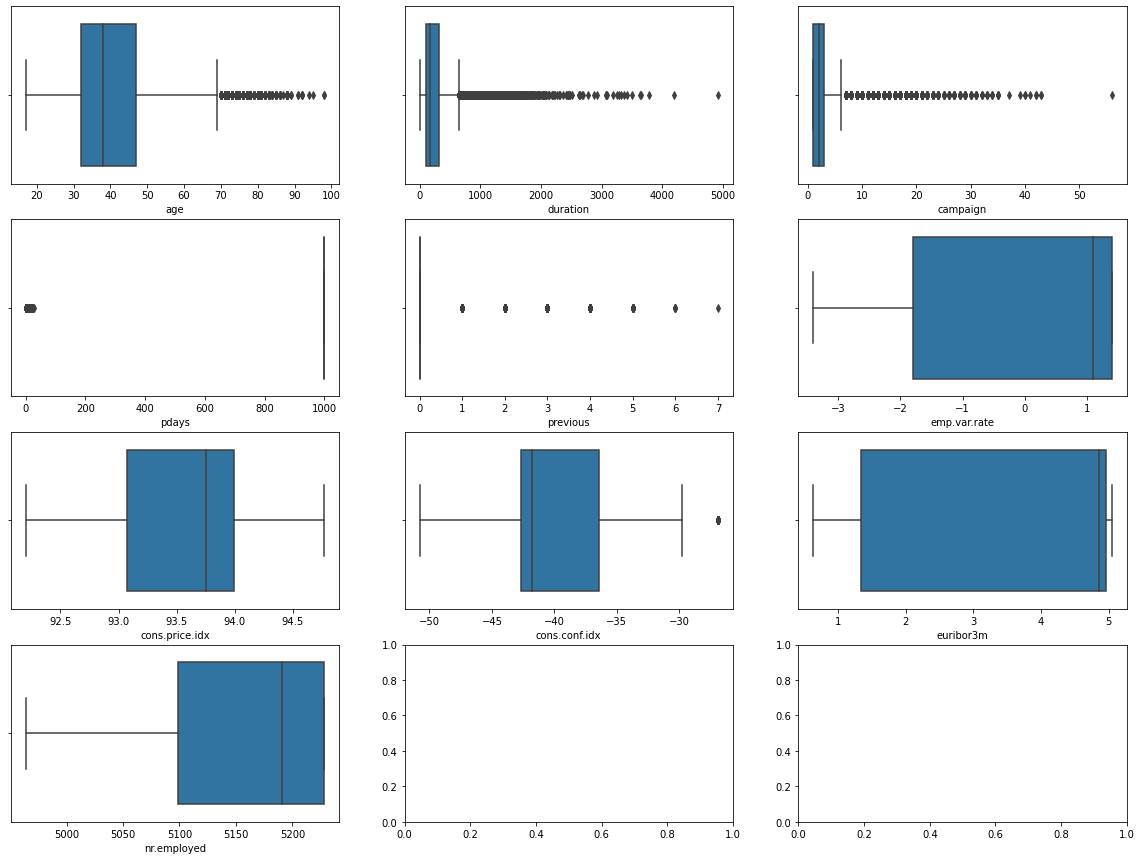

In [9]:
#boxplot of numeric columns
fig, ax =plt.subplots(4,3, figsize=(20,15))
sns.boxplot(df['age'], ax=ax[0][0]);
sns.boxplot(df['duration'], ax=ax[0][1]);
sns.boxplot(df['campaign'], ax=ax[0][2]);
sns.boxplot(df['pdays'], ax=ax[1][0]);
sns.boxplot(df['previous'], ax=ax[1][1]);
sns.boxplot(df['emp.var.rate'], ax=ax[1][2]);
sns.boxplot(df['cons.price.idx'], ax=ax[2][0]);
sns.boxplot(df['cons.conf.idx'], ax=ax[2][1]);
sns.boxplot(df['euribor3m'], ax=ax[2][2]);
sns.boxplot(df['nr.employed'], ax=ax[3][0]);
fig.show()

Age and duration column have some outliers, which can be capped at 95th percentile. 

We can create a indicator variable if customer was contacted in previous marketing campaigns or not. Other variables related to that can be dropped.

In [10]:
#variable transformation
df['previous'] = np.where(df['pdays'] == 999, "not_contacted", "contacted")  #creating a flag if customer was previously contacted or not
df = df.drop(['pdays'], axis = 1)  #dropping pdays column

In [11]:
#outlier treatment
age_95 = df['age'].quantile(0.95)
duration_95 = df['duration'].quantile(0.95)
campaign_95 = df['campaign'].quantile(0.95)

df['age'] = np.where(df['age'] > age_95, 1, df['age'])
df['duration'] = np.where(df['age'] > duration_95, 1, df['duration'])
df['campaign'] = np.where(df['age'] > campaign_95, 1, df['campaign'])

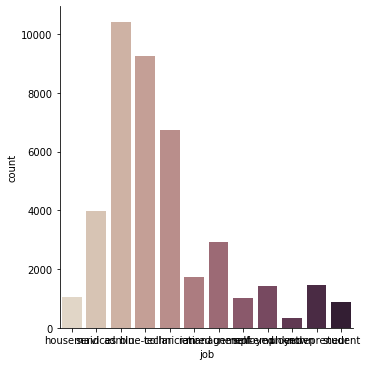

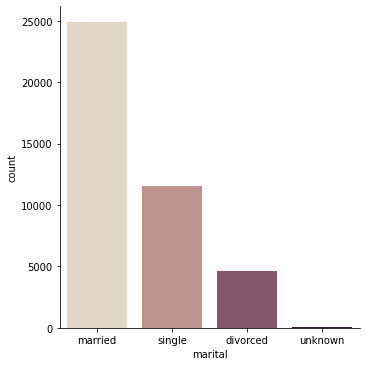

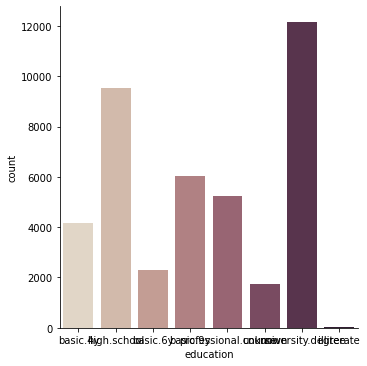

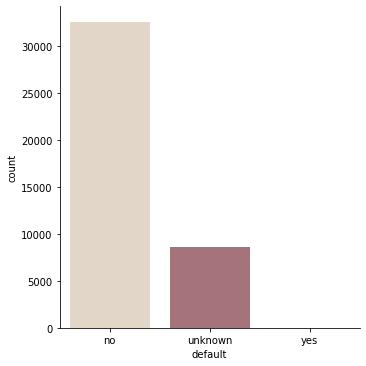

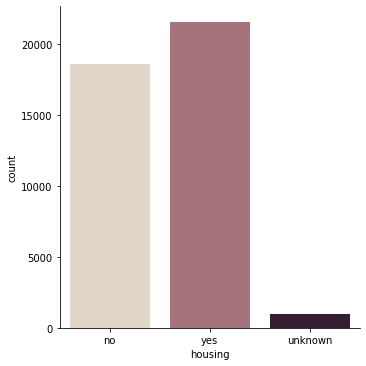

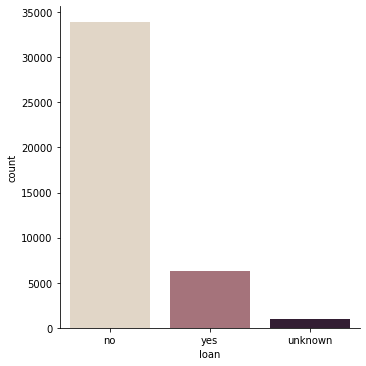

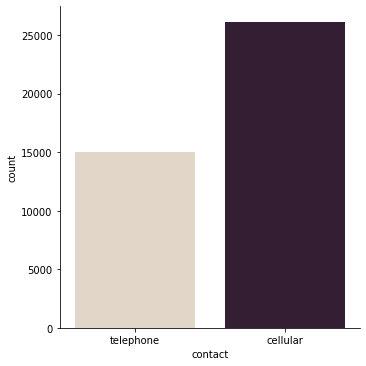

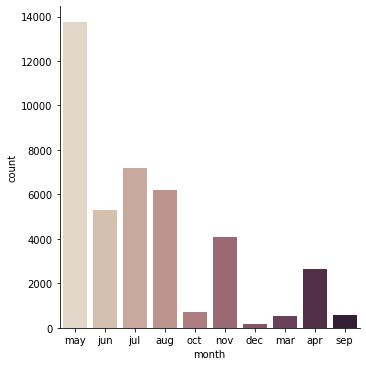

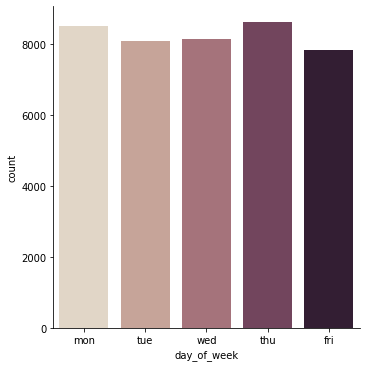

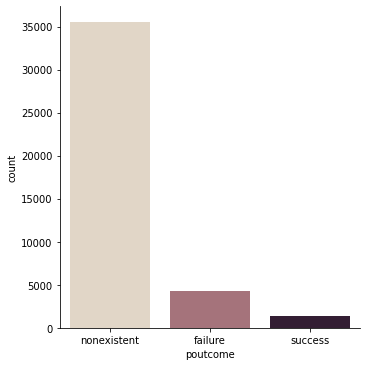

In [12]:
#barplot for categorical features - checking distribution
sns.catplot(x = "job", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "marital", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "education", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "default", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "housing", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "loan", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "contact", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "month", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "day_of_week", kind = "count", palette = "ch:0.25", data = df)
sns.catplot(x = "poutcome", kind = "count", palette = "ch:0.25", data = df)

Feature Selection

In [13]:
#checking variance of all numeric columns
#drop variables with very less variance
df.var()

age                 134.011562
duration          67225.728877
campaign              0.266610
emp.var.rate          2.467915
cons.price.idx        0.335056
cons.conf.idx        21.420215
euribor3m             3.008308
nr.employed        5220.283250
dtype: float64

In [14]:
#checking correlation among numeric columns
corr_m = df.corr()
corr_m

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.014383,-0.317948,0.204902,0.104743,-0.017102,0.216412,0.237044
duration,-0.014383,1.000000,-0.001762,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,-0.317948,-0.001762,1.000000,-0.037959,-0.009023,0.027469,-0.043752,-0.057049
emp.var.rate,0.204902,-0.027968,-0.037959,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.104743,0.005312,-0.009023,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,-0.017102,-0.008173,0.027469,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.216412,-0.032897,-0.043752,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.237044,-0.044703,-0.057049,0.906970,0.522034,0.100513,0.945154,1.000000


In [15]:
#dropping highly correlated variables
corr_m =  corr_m.abs()    #absolute correlation matrix
upper = corr_m.where(np.triu(np.ones(corr_m.shape), k = 1).astype(np.bool))   #upper triangle of correlation matrix
corr_drop = [column for column in upper.columns if any(upper[column] >= 0.75)]    #column index with correlation magnitude >= 0.75
df = df.drop(df[corr_drop], axis = 1)

In [16]:
#creating list of numeric and categorical columns
numeric = []
non_numeric = []
for col in df:
    if df[col].dtypes not in  ("float64", "int64"):
        non_numeric.append(col)
    else:
        numeric.append(col)

non_numeric = non_numeric[:-1]

print("Numeric Columns: ", numeric)
print("Categorical Columns: ", non_numeric)

Numeric Columns:  ['age', 'duration', 'campaign', 'emp.var.rate', 'cons.conf.idx']
Categorical Columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous', 'poutcome']


In [17]:
#numeric variable selection using t-test
numeric_sig = []

for col in numeric:
  y_0 = df.loc[df['y'] == 'no', col]
  y_1 = df.loc[df['y'] == 'yes', col]

  p_value = stats.ttest_ind(y_0, y_1, equal_var = False)[1]

  if p_value < 0.05:
    numeric_sig.append(col)

print("Significant numeric variables: ", numeric_sig)

Significant numeric variables:  ['age', 'duration', 'campaign', 'emp.var.rate', 'cons.conf.idx']


In [18]:
#categorical variable selection using chi square test
non_numeric_sig = []

for col in non_numeric:
    ct = pd.crosstab(df['y'], df[col], margins=True)
    obs = np.array([ct.iloc[0].values, ct.iloc[1].values])
    p_value = stats.chi2_contingency(obs)[1]
  
    if p_value < 0.05:
        non_numeric_sig.append(col)

print("Significant categorical variables: ", non_numeric_sig)

Significant categorical variables:  ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'previous', 'poutcome']


In [19]:
#variables to select
select = numeric_sig + non_numeric_sig + ['y']
df = df[select]

Preparing final data set

In [20]:
#scaling numeric columns
scaler = StandardScaler()
df.loc[:,numeric_sig] = scaler.fit_transform(df.loc[:,numeric_sig])

In [21]:
#creating data set
X =  df.loc[:, ~df.columns.isin(['y'])]
y = np.where(df['y'] == 'yes', 1, 0)

In [22]:
#one hot encoding of predictor variables
X = pd.get_dummies(X, drop_first = True)
X.head()

,age,duration,campaign,emp.var.rate,cons.conf.idx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,previous_not_contacted,poutcome_nonexistent,poutcome_success
0,1.604657,0.010471,-0.101049,0.648092,0.886447,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
1,1.691041,-0.421501,-0.101049,0.648092,0.886447,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
2,-0.036642,-0.124520,-0.101049,0.648092,0.886447,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,0.222510,-0.413787,-0.101049,0.648092,0.886447,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
4,1.604657,0.187888,-0.101049,0.648092,0.886447,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0


In [23]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

Function to check model performance

In [24]:
#accuracy metrics
def accuracy_metrics(y, y_pred, y_prob):
    results = confusion_matrix(y, y_pred) 
    print('Confusion Matrix :')
    print(results) 
    print('Accuracy Score :',accuracy_score(y, y_pred))
    print('Precision : ', precision_score(y, y_pred))
    print('Recall : ', recall_score(y, y_pred))
    print('FI Score : ', f1_score(y, y_pred, average = 'macro'))
    print('Area under the Curve : ', roc_auc_score(y, y_prob))

Model Training

In [25]:
#building logistic regression model
lr = LogisticRegression(max_iter = 500, random_state = 1)
lr = lr.fit(X_train, y_train)

In [26]:
#training performance
y_prob = lr.predict_proba(X_train)[:,1]
y_pred = lr.predict(X_train)
accuracy_metrics(y_train, y_pred, y_prob)

Confusion Matrix :
[[26683   728]
 [ 2106  1374]]
Accuracy Score : 0.9082580686931468
Precision :  0.653663177925785
Recall :  0.39482758620689656
FI Score :  0.7209348107988183
Area under the Curve :  0.9317591477873846


In [27]:
#test performance
y_prob = lr.predict_proba(X_test)[:,1]
y_pred = lr.predict(X_test)
accuracy_metrics(y_test, y_pred, y_prob)

Confusion Matrix :
[[8911  226]
 [ 690  470]]
Accuracy Score : 0.9110420510828396
Precision :  0.6752873563218391
Recall :  0.4051724137931034
FI Score :  0.7287904488757861
Area under the Curve :  0.9392989097002338


Accuracy score is greater than 90% but precision and recall is low. We need to handle the data imbalance.

In [28]:
#smoteenn algorithm for handling data imbalance
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTEENN(random_state = 41)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0)))

Before OverSampling, counts of label '1': 3480
Before OverSampling, counts of label '0': 27411 

After OverSampling, counts of label '1': 26333
After OverSampling, counts of label '0': 22995


In [29]:
#building logistic regression model
lr = LogisticRegression(max_iter = 500, random_state = 1)
lr = lr.fit(X_train_smote, y_train_smote)

In [30]:
#training performance
y_prob = lr.predict_proba(X_train)[:,1]
y_pred = lr.predict(X_train)
accuracy_metrics(y_train, y_pred, y_prob)

Confusion Matrix :
[[22590  4821]
 [  241  3239]]
Accuracy Score : 0.8361335016671523
Precision :  0.40186104218362284
Recall :  0.9307471264367816
FI Score :  0.7302997305864574
Area under the Curve :  0.9338461738449664


In [31]:
#test performance
y_prob = lr.predict_proba(X_test)[:,1]
y_pred = lr.predict(X_test)
accuracy_metrics(y_test, y_pred, y_prob)

Confusion Matrix :
[[7512 1625]
 [  64 1096]]
Accuracy Score : 0.835971642225891
Precision :  0.4027930907754502
Recall :  0.9448275862068966
FI Score :  0.7318719150146771
Area under the Curve :  0.9394576051144834


In [32]:
#building decision tree model
dt = DecisionTreeClassifier(max_depth = 10, random_state = 1)
dt = dt.fit(X_train_smote, y_train_smote)

In [33]:
#training performance
y_prob = dt.predict_proba(X_train)[:,1]
y_pred = dt.predict(X_train)
accuracy_metrics(y_train, y_pred, y_prob)

Confusion Matrix :
[[23433  3978]
 [  202  3278]]
Accuracy Score : 0.8646855071056295
Precision :  0.4517640573318633
Recall :  0.9419540229885057
FI Score :  0.764384406093379
Area under the Curve :  0.938250369953836


In [34]:
#test performance
y_prob = dt.predict_proba(X_test)[:,1]
y_pred = dt.predict(X_test)
accuracy_metrics(y_test, y_pred, y_prob)

Confusion Matrix :
[[7752 1385]
 [ 105 1055]]
Accuracy Score : 0.8552976595124794
Precision :  0.4323770491803279
Recall :  0.9094827586206896
FI Score :  0.7492165535548494
Area under the Curve :  0.90031460752605


In [35]:
#variable importance
columns = ['Variable', 'Importance']
lst = []
for i,v in enumerate(dt.feature_importances_):
    lst.append([X.columns[i], v])
    
var_imp = pd.DataFrame(lst, columns = columns)
var_imp = var_imp.sort_values(by = ['Importance'], ascending = False)
var_imp.head(20)

,Variable,Importance
1,duration,0.599128
3,emp.var.rate,0.181145
4,cons.conf.idx,0.044780
33,month_mar,0.035694
42,previous_not_contacted,0.026428
36,month_oct,0.020813
34,month_may,0.018350
0,age,0.010463
28,contact_telephone,0.007275
38,day_of_week_mon,0.006764


In [36]:
#random forest
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, bootstrap = True, max_samples = 0.7, random_state = 1)
rf = rf.fit(X_train_smote, y_train_smote)

In [37]:
#train performance
y_prob = rf.predict_proba(X_train)[:,1]
y_pred = rf.predict(X_train)
accuracy_metrics(y_train, y_pred, y_prob)

Confusion Matrix :
[[22962  4449]
 [  183  3297]]
Accuracy Score : 0.8500534136156161
Precision :  0.42563903950426024
Recall :  0.9474137931034483
FI Score :  0.7478826259054367
Area under the Curve :  0.9464390606673971


In [38]:
#test performance
y_prob = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)
accuracy_metrics(y_test, y_pred, y_prob)

Confusion Matrix :
[[7598 1539]
 [  57 1103]]
Accuracy Score : 0.8450033990482665
Precision :  0.4174867524602574
Recall :  0.9508620689655173
FI Score :  0.7425878383509193
Area under the Curve :  0.942361108490299


I will finally select random forest model to use to make strategies for my marketing campaign. As this is a marketing campaign, my main focus is to drive as much conversion as possible. So, the metric which is most important us is "recall". Here, we are getting 95% recall by targeting just 26% of overall users. This model reduces the marketing cost by 74%.

In [39]:
#variable importance
importance = rf.feature_importances_

columns = ['Variable', 'Importance']
lst = []
for i,v in enumerate(importance):
    lst.append([X.columns[i], v])
    
var_imp = pd.DataFrame(lst, columns = columns)
var_imp = var_imp.sort_values(by = ['Importance'], ascending = False)
var_imp.head(20)

,Variable,Importance
1,duration,0.415143
3,emp.var.rate,0.145981
4,cons.conf.idx,0.085553
28,contact_telephone,0.043009
42,previous_not_contacted,0.038628
44,poutcome_success,0.035923
26,default_unknown,0.032504
34,month_may,0.029674
43,poutcome_nonexistent,0.028184
0,age,0.017769
